In [1]:
%pip install seaborn


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [22]:
import pandas as pd
import numpy as np
import torch as pt

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [23]:
from pathlib import Path

len(list(Path("../../acts/Llama3/8B/chat/").iterdir()))

41

In [77]:
tensors = []
datasets = []
for i, dset_dir in enumerate(Path("../../acts/Llama3/8B/chat/").iterdir()):
    dset_name = dset_dir.name
    try:
        datasets.append(pd.read_csv(f"../../datasets/{dset_name}.csv"))
    except Exception as e:
        print(f"../../datasets/{dset_name}.csv")
        continue
    
    for file in sorted(dset_dir.iterdir(), key=lambda file_: int(str(file_).split("_")[-1].split(".")[0])):
        if "layer_12" not in str(file):
            continue
        tensors.append(pt.load(file))
        
    if i < 10 or i > 15:
        continue


../../datasets/real_world_scenarios.csv


In [78]:
activations = pt.cat(tensors, axis=0).to("cpu")

In [79]:
(activations.element_size() * activations.nelement()) / 1e6 # mb

889.73312

In [67]:
dummy_data = pd.concat([d["label"] for d in datasets], axis=0).reset_index(drop=True).to_frame()
dummy_data

,label
0,1
1,0
2,1
3,1
4,0
...,...
495,0
496,1
497,1
498,0


In [68]:
# dummy_data = pd.read_csv("../../datasets/animal_class.csv")
dummy_data["correct"] = dummy_data["label"].astype(bool)

In [69]:
dataset_size = activations.shape[0]
dataset_size

500

In [70]:
# dataset_size = 1000
# wrong_predictions_count = 500

# choices = ['A', 'B', 'C', 'D']
# dummy_data = pd.DataFrame({"prediction": np.random.choice(choices, dataset_size)})
# dummy_data["target"] = dummy_data["prediction"].copy()
# dummy_data.iloc[-wrong_predictions_count:].loc[:, "target"] = "F"
# dummy_data = dummy_data.reset_index()
# dummy_data["correct"] = dummy_data["prediction"] == dummy_data["target"]
# dummy_data

In [71]:
activation_dims = activations.shape[-1]

In [72]:
# correct_vector = np.random.normal(100, 10, activation_dims)
# incorrect_vector = np.random.normal(100, 10, activation_dims)

In [73]:
# activation_list = []
# for c in dummy_data["correct"]:
#     if c:
#         v = correct_vector + np.random.normal(0, 1, activation_dims)
#     else:
#         v = incorrect_vector + np.random.normal(0, 1, activation_dims)
#     activation_list.append(v)
# activations = pt.from_numpy(np.stack(activation_list))
# activations

In [74]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(activations)

pca = PCA(n_components=2)
pca_activations = pca.fit_transform(X_scaled)

<Axes: >

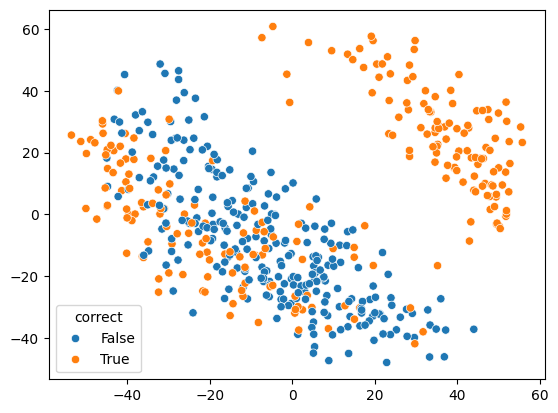

In [75]:
sns.scatterplot(x=pca_activations[:, 0], y=pca_activations[:, 1], hue=dummy_data["correct"])

In [56]:
mu = activations.mean(axis=0)

s = pt.ones(dataset_size)
s[~dummy_data["correct"]] = -1

correctness_direction = pt.mean((activations - mu) * s[:, None], dim=0)
correctness_direction

tensor([ 0.0051, -0.0016, -0.0027,  ...,  0.0122,  0.0041,  0.0151])

In [57]:
correctness_end_pca = pca.transform(scaler.transform(correctness_direction[None, :])).squeeze()
correctness_end_pca

array([ 7.87386148, 30.30978023])

In [58]:
zero_pca = pca.transform(scaler.transform([[0]*4096])).squeeze()
correctness_direction_pca = correctness_end_pca - zero_pca

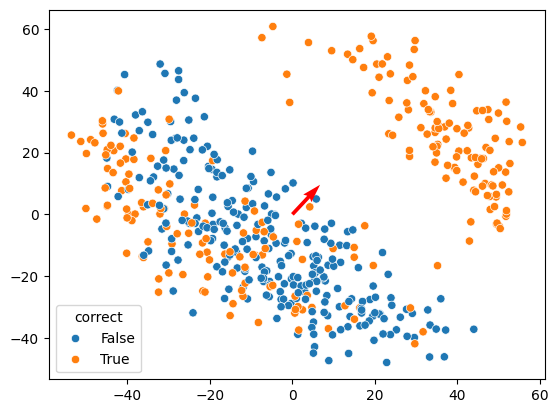

In [59]:
ax = sns.scatterplot(x=pca_activations[:, 0], y=pca_activations[:, 1], hue=dummy_data["correct"])
ax.quiver(0, 0, correctness_direction_pca[0], correctness_direction_pca[1], 
          angles='xy', scale_units='xy', scale=1,
          color='red', label='Vector')

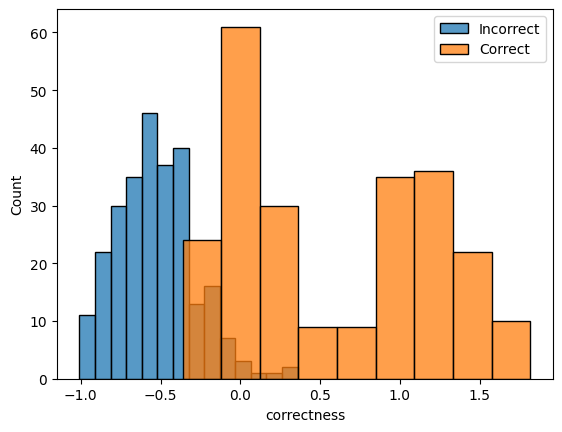

In [60]:
dummy_data["correctness"] = ((activations - mu) @ correctness_direction)
ax = sns.histplot(dummy_data[~dummy_data["correct"]]["correctness"], label="Incorrect")
ax = sns.histplot(dummy_data[dummy_data["correct"]]["correctness"], label="Correct", ax=ax)
ax.legend()

In [61]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(dummy_data["correct"], dummy_data["correctness"])
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

-0.22005582

In [62]:
roc_auc = auc(fpr, tpr)
roc_auc

0.9830508474576272

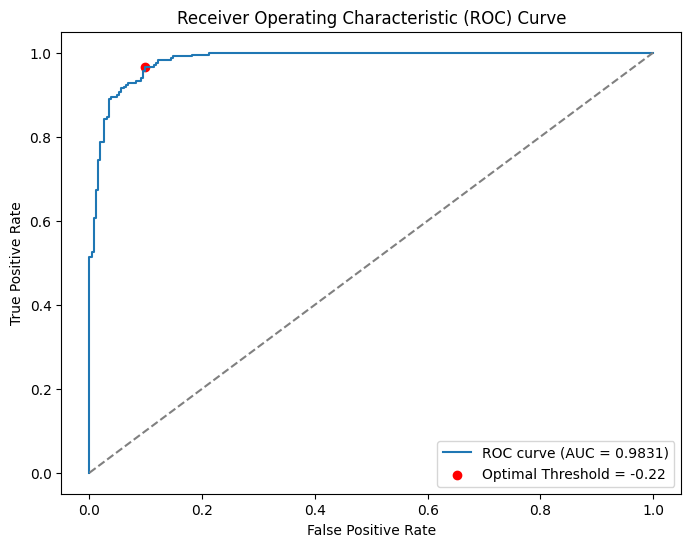

In [63]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()